In [574]:
import os
import re
import glob
import difflib
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
from dateutil import relativedelta
from sklearn import cluster, preprocessing, metrics
%matplotlib inline

# LOAD DATA TO DICTIONARY

In [423]:
path = 'C:/analyticsdev/Projects/EXPECTEDX/Alloe/data'
files = glob.glob(os.path.join(path, "*.csv"))

raw_data = [pd.read_csv(name) for name in files]
df_names = [re.findall('(?<=\.)[a-zA-Z]+(?=\.)', names) for names in files]
df_names = itertools.chain(*df_names)
raw_data = dict(zip(df_names, raw_data))

# WRANGLING FUNCS

In [424]:
answer = raw_data['answer']
answer['survey'] = answer['survey'].apply(lambda x: re.split(' (?=@)',x)[0])
answer['user'] = answer['user'].apply(lambda x: re.split(' (?=@)',x)[0])

In [425]:
answer = answer.pivot_table(index='user', 
                            columns='survey', 
                            values='answer', 
                            aggfunc=lambda x: ' '.join(str(v) for v in x))
answer = answer.add_suffix('_surv')

In [426]:
#user = raw_data['user'][['_id',
 #                        'active',
  #                       'dob',
   #                      'gender',
    #                     'heightFeet',
     #                    'heightInches',
      #                   'joined',
       #                  'weight']]

In [427]:
#main = user.merge(answer, 
 #                 how='left', 
  #                left_on='_id', 
   #               right_index=True, 
    #              sort=True)

In [428]:
main = raw_data['user'][['_id',
                         'active',
                         'dob',
                         'gender',
                         'heightFeet',
                         'heightInches',
                         'joined',
                         'weight']]

In [429]:
main['dob'] = main['dob'].apply(lambda x: pd.to_datetime(x))
main['joined'] = main['joined'].apply(lambda x: pd.to_datetime(x))

main['age'] = main['dob'].apply(lambda x: relativedelta.relativedelta(date.today(), datetime.date(x)).years)
main['act_time'] = main['joined'].apply(lambda x: (date.today() - datetime.date(x)).days)

C:\analyticsdev\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\analyticsdev\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\analyticsdev\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [430]:
chal_inv = raw_data['challengeInvitation']
chal_inv['challenge'] = chal_inv['challenge'].apply(lambda x: re.split(' (?=@)',x)[0])
chal_inv['friend'] = chal_inv['friend'].apply(lambda x: re.split(' (?=@)',x)[0])
chal_inv['user'] = chal_inv['user'].apply(lambda x: re.split(' (?=@)',x)[0])

In [431]:
chal_inv = chal_inv.pivot_table(index='user',
                                columns='challenge', 
                                values='friend',
                                aggfunc=lambda x: ' '.join(str(v) for v in x))
chal_inv = chal_inv.add_suffix('_chalinv')

In [432]:
#main = main.merge(chal_inv,
 #                 how='left',
  #                left_on='_id',
   #               right_index=True,
    #              sort=True)

Don't understand relationships between "challenger" table and "challengeInvitation" table 'user' column

In [433]:
frnd_rq = raw_data['friendship']
frnd_rq['friend'] = frnd_rq['friend'].apply(lambda x: re.split(' (?=@)',x)[0])
frnd_rq['user'] = frnd_rq['user'].apply(lambda x: re.split(' (?=@)',x)[0])

In [434]:
frnd_rq = frnd_rq.pivot_table(index='user',
                              columns='friend',
                              values='status',
                              aggfunc=lambda x: ' '.join(str(v) for v in x))
frnd_rq = frnd_rq.add_suffix('_friendid')

In [435]:
#main = main.merge(frnd_rq,
 #                 how='left',
  #                left_on='_id',
   #               right_index=True,
    #              sort=True)

In [436]:
event_ast = raw_data['assistantEvent']
event_ast['event'] = event_ast['event'].apply(lambda x: re.split(' (?=@)',x)[0])
event_ast['user'] = event_ast['user'].apply(lambda x: re.split(' (?=@)',x)[0])

In [437]:
event_ast = event_ast.pivot_table(index='user',
                                  columns='event',
                                  values='_id',
                                  aggfunc=lambda x: ' '.join(str(v) for v in x))
event_ast = event_ast.add_suffix('_eventid')

In [438]:
#main = main.merge(event_ast,
 #                 how='left',
  #                left_on='_id',
   #               right_index=True,
    #              sort=True)

In [439]:
post = raw_data['post']
post['user'] = post['user'].apply(lambda x: re.split(' (?=@)',x)[0])
post['item._class'] = post['item._class'].apply(lambda x: re.sub('[a-z].+\.(?=[A-Z])', '', str(x)))

In [440]:
post['counter'] = int(1)
post = post.pivot_table(index='user',
                        columns='item._class',
                        values='counter',
                        aggfunc='sum')

In [441]:
main = main.merge(post,
                  how='left',
                  left_on='_id',
                  right_index=True,
                  sort=True)

In [442]:
metrics_miles_time = raw_data['post'][['user','item.miles','item.time','item.positions']]
metrics_miles_time = metrics_miles_time.groupby(metrics_miles_time.user).sum()

metrics_exercise = raw_data['post'][['user','item.exercise']]
metrics_exercise['counter'] = int(1)

metrics_chals_sent = pd.DataFrame(chal_inv.count(axis=1), columns={'chal_sent'})
metrics_chals_unique = pd.DataFrame(chal_inv.nunique(axis=1), columns={'chal_unique'})
metrics_chals_uratio = metrics_chals_sent.join(metrics_chals_unique)
metrics_chals_uratio['chal_uni_frnd'] = metrics_chals_uratio['chal_sent']/metrics_chals_uratio['chal_unique']

metrics_frnd_sent = pd.DataFrame(frnd_rq.count(axis=1), columns={'frnd_sent'})

C:\analyticsdev\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [443]:
metrics_exercise = metrics_exercise.pivot_table(index='user',
                                                columns='item.exercise',
                                                values='counter',
                                                aggfunc='sum')

In [444]:
main = main.merge(metrics_miles_time,
                  how='left',
                  left_on='_id',
                  right_index=True,
                  sort=True)

main = main.merge(metrics_exercise,
                  how='left',
                  left_on='_id',
                  right_index=True,
                  sort=True)

main = main.merge(metrics_chals_uratio,
                  how='left',
                  left_on='_id',
                  right_index=True,
                  sort=True)

main = main.merge(frnd_rq.apply(pd.value_counts, axis=1)[['ACCEPTED','PENDING','WAITING']],
                  how='left',
                  left_on='_id',
                  right_index=True,
                  sort=True)

main.drop(353, inplace=True) #Record is all NaN
main.drop(['dob','joined','CompanyMessage'], axis=1, inplace=True)

In [445]:
#event = main.filter(regex='_eventid')
#friend = main.filter(regex='_friendid')

GIVE 'EVENT' AND 'FRIEND' THEIR OWN TABLES AND SCORE THEM ADDED TO 'MAIN' DATA FRAME

EXTRA COLUMNS LIKE "ACCEPTED ACCEPTED" HAVE A 1 OCCASIONALLY. NOT SURE IF ISSUE WITH RAW DATA OR 'APPLY' FUNCTION

In [446]:
split = np.split(main, [8], axis=1)
nas = split[1].isnull()
split[1][nas] = 0

In [447]:
main = split[0].join(split[1])
main = main.join(pd.get_dummies(main['gender']))

In [448]:
clust_set = main.loc[:,'heightFeet':]
clust_set.fillna(clust_set.median(), inplace=True)

In [449]:
clust_set

,heightFeet,heightInches,weight,age,act_time,BloodPressureCheckIn,Challenger,CholesterolCheckIn,EventCheckIn,FitbitCheckIn,...,SWIMMING,WEIGHTS,chal_sent,chal_unique,chal_uni_frnd,ACCEPTED,PENDING,WAITING,FEMALE,MALE
185,5.0,3.0,143.75,35,976,3.0,11.0,2.0,2.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,3.0,0.0,1,0
134,5.0,11.0,170.00,45,976,0.0,15.0,2.0,1.0,0.0,...,0.0,0.0,2.0,1.0,2.0,18.0,7.0,0.0,0,1
110,6.0,6.0,194.90,2,976,0.0,8.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,0,1
198,5.0,11.0,191.00,33,976,10.0,12.0,1.0,0.0,0.0,...,0.0,1.0,3.0,2.0,1.5,6.0,0.0,1.0,0,1
228,5.0,6.0,160.00,34,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0
43,5.0,10.0,180.00,42,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0,1
53,5.0,6.0,160.00,6,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,1
0,5.0,6.0,160.00,31,976,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,4.0,1.0,4.0,30.0,10.0,3.0,0,0
315,5.0,11.0,185.80,27,976,1.0,13.0,0.0,5.0,77.0,...,0.0,0.0,3.0,2.0,1.5,47.0,1.0,0.0,0,1
15,5.0,10.0,185.00,31,975,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0,1


In [450]:
ss = preprocessing.StandardScaler(with_mean=False)

In [458]:
processed = pd.DataFrame(ss.fit_transform(clust_set), columns=clust_set.columns, index=clust_set.index)

In [459]:
processed

,heightFeet,heightInches,weight,age,act_time,BloodPressureCheckIn,Challenger,CholesterolCheckIn,EventCheckIn,FitbitCheckIn,...,SWIMMING,WEIGHTS,chal_sent,chal_unique,chal_uni_frnd,ACCEPTED,PENDING,WAITING,FEMALE,MALE
185,2.225310,0.715237,0.577769,3.651151,3.301396,5.808401,4.197726,11.185462,0.119695,0.000000,...,0.000000,0.000000,1.343531,1.919179,1.743721,0.053345,0.581741,0.000000,2.041241,0.000000
134,2.225310,2.622535,0.683275,4.694338,3.301396,0.000000,5.724171,11.185462,0.059847,0.000000,...,0.000000,0.000000,2.687063,1.919179,3.487441,0.960216,1.357395,0.000000,0.000000,2.012632
110,2.670372,1.430474,0.783355,0.208637,3.301396,0.000000,3.052891,5.592731,0.000000,0.626033,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.426763,0.000000,0.050985,0.000000,2.012632
198,2.225310,2.622535,0.767680,3.442514,3.301396,19.361337,4.579337,5.592731,0.000000,0.000000,...,0.000000,0.027752,4.030594,3.838358,2.615581,0.320072,0.000000,0.050985,0.000000,2.012632
228,2.225310,1.430474,0.643082,3.546833,3.301396,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.053345,0.000000,0.000000,0.000000,0.000000
43,2.225310,2.384123,0.723468,4.381382,3.301396,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.160036,0.000000,0.000000,0.000000,2.012632
53,2.225310,1.430474,0.643082,0.625912,3.301396,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.053345,0.193914,0.000000,0.000000,2.012632
0,2.225310,1.430474,0.643082,3.233877,3.301396,0.000000,1.908057,0.000000,0.059847,0.000000,...,0.000000,0.000000,5.374126,1.919179,6.974882,1.600360,1.939135,0.152954,0.000000,0.000000
315,2.225310,2.622535,0.746779,2.816603,3.301396,1.936134,4.960948,0.000000,0.299237,16.068182,...,0.000000,0.000000,4.030594,3.838358,2.615581,2.507231,0.193914,0.000000,0.000000,2.012632
15,2.225310,2.384123,0.743564,3.233877,3.298014,1.936134,0.381611,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.041751,0.000000,0.000000,2.012632


In [532]:
agg = cluster.AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='complete')
labels = agg.fit_predict(processed)
clust_set['Agg_Clust'] = labels
clust_set['Agg_Clust'].value_counts()

1    460
2     68
0     56
3      6
Name: Agg_Clust, dtype: int64

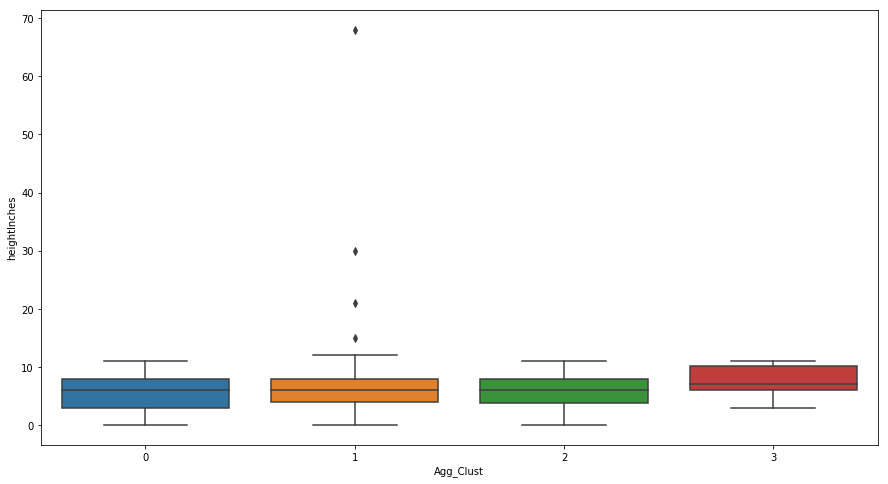

In [533]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Agg_Clust', y='heightInches', data=clust_set)

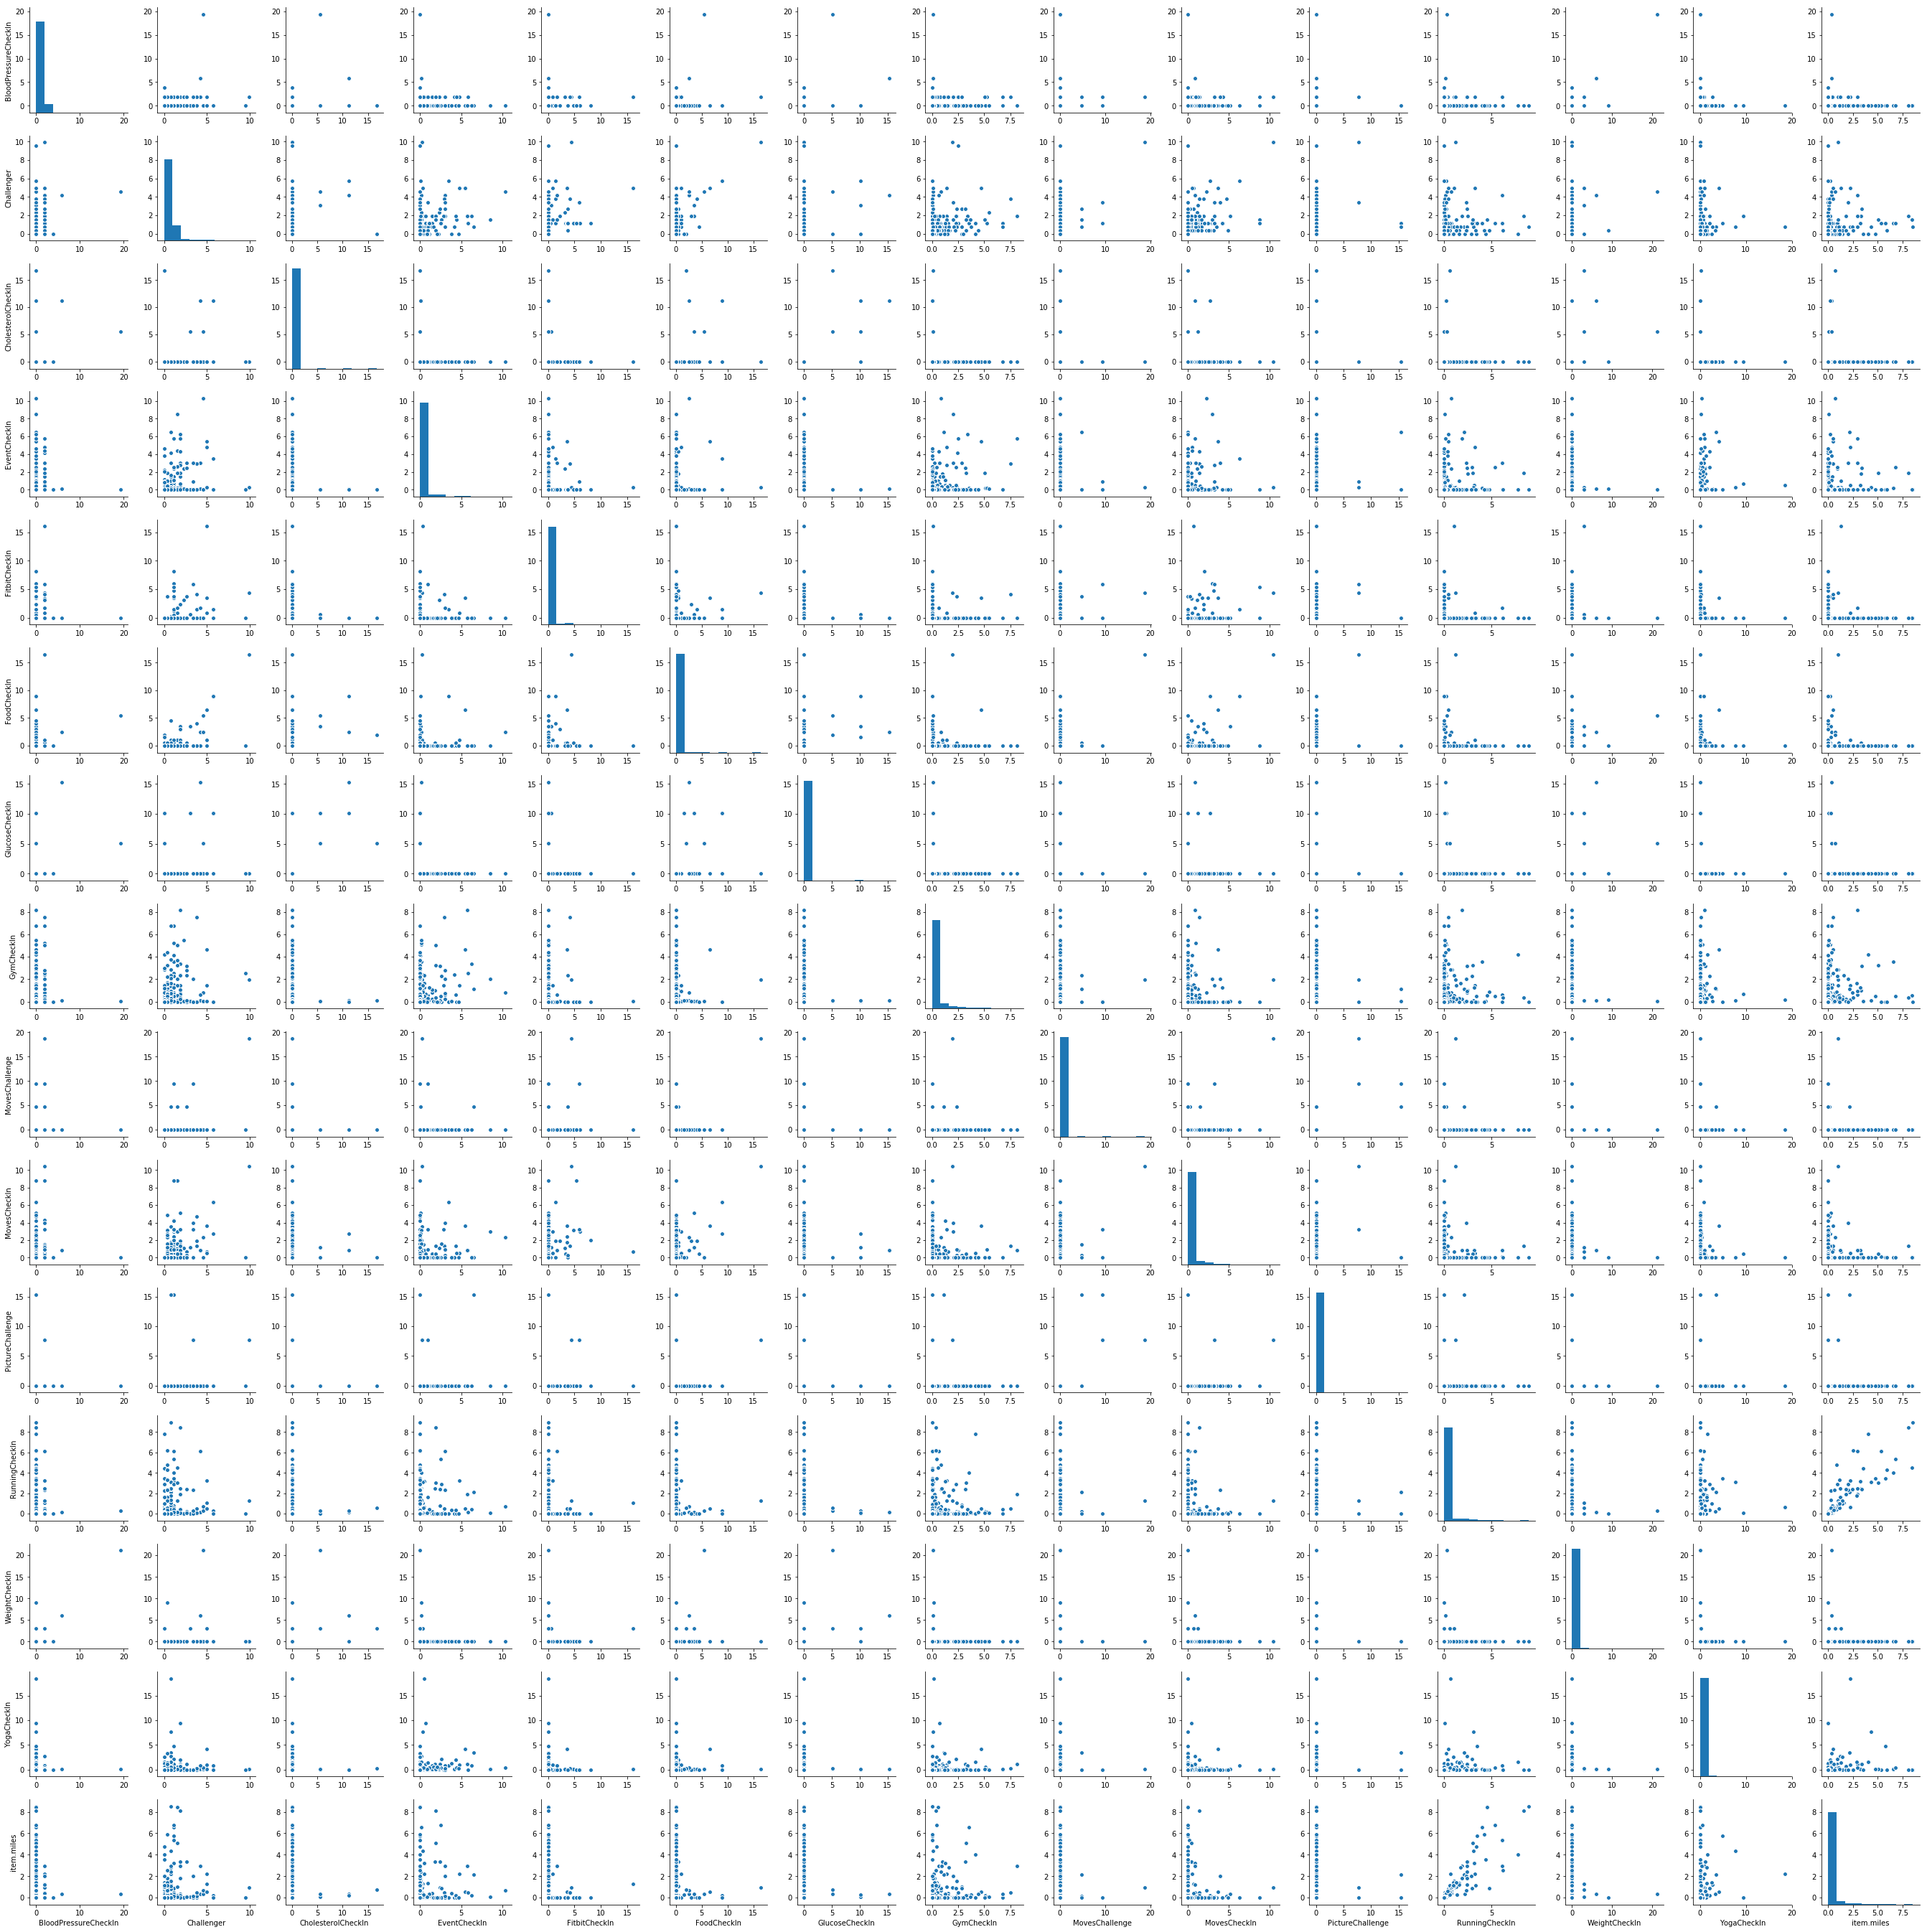

In [602]:
sns.pairplot(data=processed.iloc[:,5:20])

In [548]:
dbs = cluster.DBSCAN(eps=2, min_samples=6)
labels = dbs.fit_predict(processed)
clust_set['DBS_Clust'] = labels
clust_set['DBS_Clust'].value_counts()

 0    214
-1    207
 1    151
 3     12
 2      6
Name: DBS_Clust, dtype: int64

In [549]:
clust_set

,heightFeet,heightInches,weight,age,act_time,BloodPressureCheckIn,Challenger,CholesterolCheckIn,EventCheckIn,FitbitCheckIn,...,chal_sent,chal_unique,chal_uni_frnd,ACCEPTED,PENDING,WAITING,FEMALE,MALE,Agg_Clust,DBS_Clust
185,5.0,3.0,143.75,35,976,3.0,11.0,2.0,2.0,0.0,...,1.0,1.0,1.0,1.0,3.0,0.0,1,0,3,-1
134,5.0,11.0,170.00,45,976,0.0,15.0,2.0,1.0,0.0,...,2.0,1.0,2.0,18.0,7.0,0.0,0,1,3,-1
110,6.0,6.0,194.90,2,976,0.0,8.0,1.0,0.0,3.0,...,0.0,0.0,0.0,8.0,0.0,1.0,0,1,3,-1
198,5.0,11.0,191.00,33,976,10.0,12.0,1.0,0.0,0.0,...,3.0,2.0,1.5,6.0,0.0,1.0,0,1,3,-1
228,5.0,6.0,160.00,34,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,2
43,5.0,10.0,180.00,42,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0,1,1,0
53,5.0,6.0,160.00,6,976,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0,1,1,0
0,5.0,6.0,160.00,31,976,0.0,5.0,0.0,1.0,0.0,...,4.0,1.0,4.0,30.0,10.0,3.0,0,0,2,-1
315,5.0,11.0,185.80,27,976,1.0,13.0,0.0,5.0,77.0,...,3.0,2.0,1.5,47.0,1.0,0.0,0,1,2,-1
15,5.0,10.0,185.00,31,975,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,26.0,0.0,0,1,1,-1


In [563]:
sc = cluster.SpectralClustering(n_clusters=4)
labels = sc.fit_predict(processed)
clust_set['SC_Clust'] = labels
clust_set['SC_Clust'].value_counts()

0    331
2    114
3     84
1     61
Name: SC_Clust, dtype: int64

In [564]:
km = cluster.KMeans(n_clusters=4)
labels = km.fit_predict(processed)
clust_set['KM_Clust'] = labels
clust_set['KM_Clust'].value_counts()

0    471
1     73
3     41
2      5
Name: KM_Clust, dtype: int64

In [583]:
clust_set.columns

Index(['heightFeet', 'heightInches', 'weight', 'age', 'act_time',
       'BloodPressureCheckIn', 'Challenger', 'CholesterolCheckIn',
       'EventCheckIn', 'FitbitCheckIn', 'FoodCheckIn', 'GlucoseCheckIn',
       'GymCheckIn', 'MovesChallenge', 'MovesCheckIn', 'PictureChallenge',
       'RunningCheckIn', 'WeightCheckIn', 'YogaCheckIn', 'item.miles',
       'item.time', 'item.positions', 'CARDIO', 'FITNESS', 'OTHER', 'SWIMMING',
       'WEIGHTS', 'chal_sent', 'chal_unique', 'chal_uni_frnd', 'ACCEPTED',
       'PENDING', 'WAITING', 'FEMALE', 'MALE', 'Agg_Clust', 'DBS_Clust',
       'AP_Clust', 'SC_Clust', 'KM_Clust'],
      dtype='object')

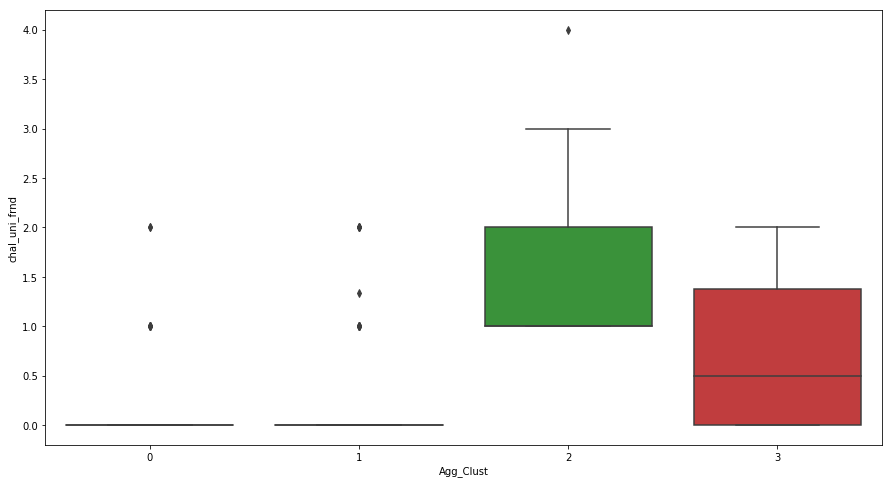

In [593]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Agg_Clust', y='chal_uni_frnd', data=clust_set)

In [575]:
metrics.silhouette_score(clust_set, labels=clust_set['KM_Clust'], metric='cosine')

-0.36611642801711614

In [591]:
metrics.calinski_harabaz_score(clust_set, labels=clust_set['KM_Clust'])

358.27867410914865

In [581]:
metrics.calinski_harabaz_score(clust_set, labels=clust_set['KM_Clust'])

358.27867410914865